# <font color='Goldenrod'>*Yellow*</font><font color=#303030> is the new </font> *black*

## <font color=#303030> Abstract</font>
The creation and propagation of false information has existed since the dawn of time.
Behind these misleading elements are often hidden political or financial intentions, in order to gain credit or make competitors lose it.
With the advent of the Internet and the ever faster and more direct flow of information, it is becoming easier every day to deceive your fellow citizens and to be fooled.
The term *fake news* took on a new dimension during the 2016 American presidential election, when Donald Trump used it extensively to describe the media coverage about himself. In this instantaneous era, it becomes crucial to be able to be critical of the information received. With this work, we want to highlight the risks related to the propagation of false information by using the fakes news themselves, from the Liar database. The power that these fake new vehicles hold is mostly in the use and resonance we make of them. Our credulity becomes credibility, it's up to us to turn the equation the other way around!

------

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import urllib
from urllib.request import Request, urlopen
import json
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from PIL import Image

<div class="alert alert-block alert-info"><b>Our internal milestones up until project Milestone 2:</b><br />
<br />
- <b>10 November</b>:	Load the data, clear the data and familiarize with it.<br />
- <b>15 November</b>:	Compute the first statistics and simple data visualisation with matplotlib.<br />
- <b>20 November</b>:	Refine data story with a structured plan according to our exploration of the data.<br />
- <b>25 November</b>:	Explore fitting visualisation types (graphs,chord diagrams,maps) for each question.<br />

</div>

------

## <font color=#303030> Data Loading and Cleaning</font>

The first thing to do when studying the proportion of veracity and extent of information is to obtain the data. Here, the data comes from the liar_dataset and is downloaded from the following address. Since these data are initially used to detect probable false news, they are divided into two sets: one for training and one for testing. For a first exploratory analysis of these data, we will only use the training set which gathers the majority of the data. All the figures given below will therefore be given through the filter of the sampling assumed to be random between the two sets, in addition to the probable bias of entry into the database mentioned above. 

In [72]:
datapath = 'data/liar_dataset/'

The files are simple *tsv* which is similar to *csv* with tabs instead of comma. All the columns names are known from the `README` files that accompagne the data

* **Column 1**: the ID of the statement ([ID].json).
* **Column 2**: the label.
* **Column 3**: the statement.
* **Column 4**: the subject(s).
* **Column 5**: the speaker.
* **Column 6**: the speaker's job title.
* **Column 7**: the state info.
* **Column 8**: the party affiliation.
* **Column 9-13**: the total credit history count, including the current statement.
    * **9**: barely true counts.
    * **10**: false counts.
    * **11**: half true counts.
    * **12**: mostly true counts.
    * **13**: pants on fire counts.
* **Column 14**: the context (venue / location of the speech or statement).

In [73]:
columns = ['ID', 
           'Label', 
           'Statement', 
           'Subject', 
           'Speaker', 
           'Job title', 
           'Home State', 
           'Party Affiliations', 
           'Barely True Counts', 
           'False Counts', 
           'Half True Counts', 
           'Mostly True Counts', 
           'Pants on Fire Counts', 
           'Context']
liar_df = pd.read_csv(datapath + 'train.tsv',delimiter='\t',encoding='utf-8', names = columns)
liar_df.head(2)

,ID,Label,Statement,Subject,Speaker,Job title,Home State,Party Affiliations,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.


------

Since we wish to extend our analysis to other fields that are not accessible with the initial data, we will use the politifact [API](https://www.politifact.com//api/v/2/statement/1123/?format=json) in due course to enrich our data. For example, from a temporal analysis perspective, we can imagine integrating the date of the classified intervention into our data table. The same applies to obtaining the entire quotation in question.

This function allows to extract additionnal information from the politifact website by downloading the json source file and returning the json structure parsed.

In [74]:
def get_additional_info(ID):
    idx =  re.search("[0-9]*", ID)
    req = Request('http://www.politifact.com//api/v/2/statement/'+idx.group()+'/?format=json', headers={'User-Agent': 'Mozilla/5.0'})
    response = urllib.request.urlopen(req, timeout=10).read().decode('utf-8')
    a = json.loads(response)
    return a

In [75]:
print(BeautifulSoup(get_additional_info("1123.json")['statement'], 'html.parser').prettify())

<p>
 Health care reform legislation is “likely to mandate free ‘sex change’ surgeries.”
</p>


In [76]:
liar_df['Date'] = pd.Series(np.zeros(len(liar_df)), index=liar_df.index)
liar_df['Date'] = pd.to_datetime(liar_df['Date'])

In [77]:
#Exemple of how to use the function to enrich.
#for i in range(0,len(liar_df)):
#    liar_df.loc[i,'Date'] = get_additional_info(liar_df.loc[i,'ID'])['statement_date']

>All of the result and interpretation we can have from this dataset are conditionned on it. More precisely, the dataset has been constructed from differents sources of media. This selection can be biased. To lower the impact of this bias, the authors have make sure to balance the numbers of article extrated between the two american political parties. But this balance can or cannot represent the reality. It can be interesting to check it the sampling can be considered as representative or not.

In [78]:
def get_truth_distribution(data, col_name, count_threshold, normalize = True):
    df = data[[col_name, "ID", "Label"]]
    df.columns = [col_name, "Percent", "Label"]
    col_subject = df.groupby([col_name, "Label"]).count()[["Percent"]]
    col_subject = col_subject.unstack('Label')
    col_subject = col_subject.fillna(0)
    col_subject = col_subject[[('Percent', 'false'), ('Percent', 'pants-fire'), ('Percent', 'barely-true'),('Percent', 'half-true'),('Percent', 'mostly-true'),('Percent', 'true')]]
    col_subject = col_subject[col_subject.sum(axis = 1) >= count_threshold]
    if normalize == True:
        col_subject = col_subject.div(col_subject.sum(axis = 1),axis = 'index')
    col_subject = col_subject.sort_values(by=[('Percent', 'false')], ascending = False)
    return col_subject

---
## <font color=#303030>What are the main subjects falsely propagated in the United States?</font> 

We now want to study which labels are most often reported by subject. To do this, we first check that the labels indicated in the Readme file of the initial database are those found after the import of the database.

In [79]:
liar_df['Label'].unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

This is indeed the case.

In [80]:
subject_distribution = get_truth_distribution(liar_df, "Subject", 100)

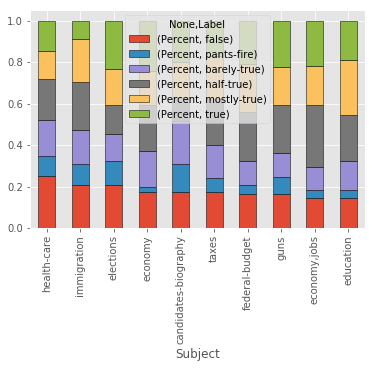

In [81]:
plt.style.use('ggplot')
subject_distribution.plot(kind='bar', stacked=True, ec='black')

We can see that the health sector is the most affected by the spread of false news here. While keeping in mind the possible biases of the analysis, it is not surprising to find this theme in the foreground. Indeed, all American citizens are concerned by this particular subject and it is no secret that health costs are a major topic of debate in the United States. In order to win public opinion, or to try to discredit its competitors, this seems to be a privileged subject, just like immigration policies.

---
## <font color=#303030>  What are the preferred formats for which topics?</font>

We would now like to study which are the preferred dissemination formats according to the subject of study. The results presented here are only a rough outline of what they will be in the future, as a finer breakdown of topics must be done for interventions that contain several of them.

### <font color=#856514>  What are the preferred context to lie? </font>

In [82]:
context_distribution = get_truth_distribution(liar_df, "Context", 100) 
context_distribution

Percent                                               \
Label                 false pants-fire barely-true half-true mostly-true   
Context                                                                    
an interview       0.253275   0.056769    0.131004  0.205240    0.205240   
a radio interview  0.226415   0.084906    0.179245  0.207547    0.132075   
a press release    0.183857   0.058296    0.152466  0.206278    0.201794   
a news release     0.182573   0.091286    0.186722  0.190871    0.170124   
a tweet            0.179487   0.108974    0.147436  0.147436    0.243590   
a speech           0.158879   0.037383    0.112150  0.252336    0.233645   
a TV ad            0.150000   0.072222    0.216667  0.255556    0.200000   
a campaign ad      0.143939   0.053030    0.363636  0.234848    0.121212   
a television ad    0.138211   0.089431    0.243902  0.308943    0.154472   

                             
Label                  true  
Context                      
an interview       0.148472  
a radio interview  0.169811  
a press release    0.197309  
a news release     0.178423  
a tweet            0.173077  
a speech           0.205607  
a TV ad            0.105556  
a campaign ad      0.083333  
a television ad    0.065041

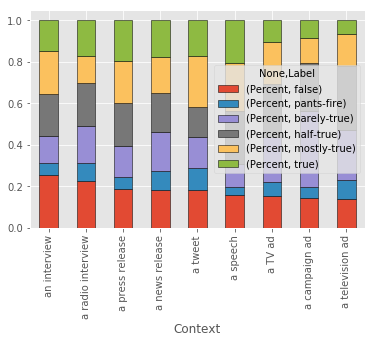

In [83]:
plt.style.use('ggplot')
context_distribution.plot(kind='bar', stacked=True, ec='black')

### <font color=#856514>  Are statements in debates more likely to be lies, compared to other speeches? </font> 

           Percent                                                   
Label        false pants-fire barely-true half-true mostly-true  true
Context                                                              
a debate.  0.28125    0.15625     0.03125     0.125     0.15625  0.25


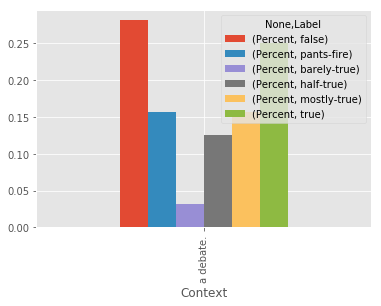

In [84]:
debate = liar_df[liar_df["Context"] == "a debate."]
debate = get_truth_distribution(debate, "Context", 10)
print(debate)
plt.style.use('ggplot')
debate.plot(kind='bar')

It seems that the debate are quite polarised in truth distribution. Debater either say completly true or completly false information. The goal in a mediatised debate is not to find the best solution to a problem but to win the debate by getting the more agreement from the audiance. Very polarised idea are then used and false information are intentionaly used because their is no possible immediate fact checking.

### <font color=#856514>  What are the preferred format for witch topic? </font> 

In [85]:
df = liar_df[["Context", "ID", "Subject"]]
df.columns = ["Context", "Percent", "Subject"]
col_subject = df.groupby(["Context", "Subject"]).count()[["Percent"]]
col_subject = col_subject.unstack('Subject')
col_subject = col_subject.fillna(0)
#col_subject = col_subject[[('Percent', 'false'), ('Percent', 'pants-fire'), ('Percent', 'barely-true'),('Percent', 'half-true'),('Percent', 'mostly-true'),('Percent', 'true')]]
col_subject = col_subject[col_subject.sum(axis = 1) >= 100]
col_subject = col_subject.div(col_subject.sum(axis = 1),axis = 'index')
col_subject = col_subject.loc[:, (col_subject != 0).any(axis=0)]
col_subject.head(3)

Percent                             \
Subject        climate-change,environment health-care state-finances   
Context                                                                
a TV ad                          0.005556    0.033333       0.000000   
a campaign ad                    0.007576    0.015152       0.000000   
a news release                   0.000000    0.024896       0.004149   

                                                                            \
Subject        education      guns     crime   nuclear immigration history   
Context                                                                      
a TV ad         0.027778  0.005556  0.005556  0.005556    0.022222     0.0   
a campaign ad   0.000000  0.000000  0.000000  0.007576    0.000000     0.0   
a news release  0.020747  0.008299  0.004149  0.000000    0.012448     0.0   

                                         ...             \
Subject        foreign-policy            ...              
Context                                  ...              
a TV ad              0.022222            ...              
a campaign ad        0.000000            ...              
a news release       0.000000            ...              

                                                \
Subject        health-care,states,transparency   
Context                                          
a TV ad                                    0.0   
a campaign ad                              0.0   
a news release                             0.0   

                                                              \
Subject        income,jobs,state-budget,state-finances,taxes   
Context                                                        
a TV ad                                                  0.0   
a campaign ad                                            0.0   
a news release                                           0.0   

                                                 \
Subject        job-accomplishments,jobs,workers   
Context                                           
a TV ad                                     0.0   
a campaign ad                               0.0   
a news release                              0.0   

                                                \
Subject        jobs,occupy-wall-street,workers   
Context                                          
a TV ad                                    0.0   
a campaign ad                              0.0   
a news release                             0.0   

                                                           \
Subject        jobs,state-finances,tourism,transportation   
Context                                                     
a TV ad                                               0.0   
a campaign ad                                         0.0   
a news release                                        0.0   

                                                               \
Subject        labor,legal-issues,state-budget,unions,workers   
Context                                                         
a TV ad                                                   0.0   
a campaign ad                                             0.0   
a news release                                            0.0   

                                                                        \
Subject        labor,public-safety legal-issues,marijuana,polls,states   
Context                                                                  
a TV ad                        0.0                                 0.0   
a campaign ad                  0.0                                 0.0   
a news release                 0.0                                 0.0   

                                                                
Subject        state-budget,stimulus state-budget,transparency  
Context                                                         
a TV ad                          0.0                       0.0  
a campaign ad       

### <font color=#856514> Compare distribution of fake news between traditional press, speeches and social media </font> 

The Internet and social networks seem to represent an ideal platform for the spread of false news, as they are anonymous, free and widely available. We would like to compare the distribution of labels assigned to news between traditional media and those from the Internet.

In [86]:
context_distribution = get_truth_distribution(liar_df, "Context", 10, normalize = False) 
context_distribution.head()

Percent                                                   
Label             false pants-fire barely-true half-true mostly-true  true
Context                                                                   
an interview       58.0       13.0        30.0      47.0        47.0  34.0
a news release     44.0       22.0        45.0      46.0        41.0  43.0
a press release    41.0       13.0        34.0      46.0        45.0  44.0
a speech           34.0        8.0        24.0      54.0        50.0  44.0
a tweet            28.0       17.0        23.0      23.0        38.0  27.0

* <font color=#ff6600> **Traditional press: **</font> 

In [87]:
traditional_press_regex = re.compile(r'\b(ABC|TV|CNN|MSNBC|radio|interview|newspaper|press)[s]*\b' ,re.I)
traditional_press_sets = context_distribution[context_distribution.index.str.contains(traditional_press_regex, regex=True) == True]
traditional_press_sets.sum()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


         Label      
Percent  false          344.0
         pants-fire      97.0
         barely-true    278.0
         half-true      366.0
         mostly-true    334.0
         true           281.0
dtype: float64

* <font color=#ff6600> **Social media: **</font> 

In [88]:
social_media_regex = re.compile(r'\b(Facebook|blog|twitter|my space|newsletter|video|email|tweet|social media|YouTube)[s]*\b' ,re.I)
social_media_sets = context_distribution[context_distribution.index.str.contains(social_media_regex, regex=True) == True]
social_media_sum =social_media_sets.sum()
social_media_sum

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


         Label      
Percent  false          111.0
         pants-fire      74.0
         barely-true     87.0
         half-true       94.0
         mostly-true     88.0
         true            71.0
dtype: float64

* <font color=#ff6600> **Speech: **</font>

In [89]:
speech_regex = re.compile(r'\b(speech)[s]*\b' ,re.I)
speech_sets = context_distribution[context_distribution.index.str.contains(speech_regex, regex=True) == True]
speech_sets.sum()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


         Label      
Percent  false          80.0
         pants-fire     18.0
         barely-true    54.0
         half-true      90.0
         mostly-true    91.0
         true           78.0
dtype: float64

---
## <font color=#303030> What are the most prominent professions among the liars?</font> 

From now on, we would like to know which professions are most often reported as liars. Before that, we study the distribution of the categorization of reported news according to the profession of their propagator.

### <font color=#856514> Professions truth distribution ? </font> 

In [90]:
profession_distribution = get_truth_distribution(liar_df, "Job title", 30) 
profession_distribution.head()

Percent                         \
Label                                       false pants-fire barely-true   
Job title                                                                  
President-Elect                          0.369963   0.190476    0.175824   
Congresswoman                            0.360000   0.220000    0.160000   
Attorney General                         0.303030   0.030303    0.060606   
Congressman                              0.300000   0.025000    0.125000   
Speaker of the House of Representatives  0.280000   0.040000    0.180000   

                                                                         
Label                                   half-true mostly-true      true  
Job title                                                                
President-Elect                          0.142857    0.098901  0.021978  
Congresswoman                            0.120000    0.060000  0.080000  
Attorney General                         0.272727    0.212121  0.121212  
Congressman                              0.212500    0.175000  0.162500  
Speaker of the House of Representatives  0.160000    0.080000  0.260000

### <font color=#856514>  What are the most prominent professions in the dataset ? </font> 

In [91]:
jobs = liar_df.groupby("Job title").count()
jobs = jobs.sort_values(by=['ID'], ascending = False)
jobs = jobs[["ID"]]
jobs.head()

,ID
Job title,
President,492
U.S. Senator,479
Governor,391
President-Elect,273
U.S. senator,263


### <font color=#856514> And among the liars ? </font> 

For each Statement, we can access the job title of the speaker. That way, we can access the most frequent jobs in the liar groups for this specific dataset.

In [92]:
lie = liar_df[liar_df['Label'] == 'false']
jobs_lie = lie.groupby("Job title").count()
jobs_lie = jobs_lie[["ID"]]

In [93]:
jobs_lie = jobs_lie.sort_values(by=['ID'], ascending = False)
jobs_lie.head()

,ID
Job title,
President-Elect,101
Governor,75
President,68
U.S. Senator,66
U.S. senator,51


Because all the jobs don't have the same media coverage, it is more interesting to have the percentage of lie of the job than the raw numbers themselves

In [94]:
jobs_lie = jobs_lie.join(jobs, lsuffix = '_lie', rsuffix = '_total')
jobs_lie["ratio (%)"] =jobs_lie["ID_lie"]/jobs_lie["ID_total"]*100
jobs_lie = jobs_lie.sort_values(by=['ID_total'], ascending = False)

### <font color=#856514>  What about the politics? </font> 

Since politicians are very often the most visible and most influential and those whose message is most widely conveyed, we can study this area more precisely.

The people that have a political message generaly have a party affiliation.

In [95]:
lie_party = lie[lie['Party Affiliations'] != 'none']
lie_party = lie_party.groupby("Job title").count()
lie_party = lie_party[["ID"]].sort_values(by=['ID'], ascending = False)
lie_party.head(2)

,ID
Job title,
President-Elect,101
Governor,75


In [96]:
politics_regex = re.compile(r'\b(mayor|president|council|house|candidate|political|assembly|republican|governor|senator)[s]*\b' ,re.I)
politics_liar_sets = jobs_lie[jobs_lie.index.str.contains(politics_regex, regex=True) == True]
politics_liar_sets.head(2)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,ID_lie,ID_total,ratio (%)
Job title,,,
President,68,492,13.821138
U.S. Senator,66,479,13.778706


---
## <font color=#303030> Which political parties tend to lie the most?</font> 

In [97]:
col = "Party Affiliations"
df = liar_df[[col, "ID", "Label"]]
df.columns = [col, "Count", "Label"]
col_subject = df.groupby([col, "Label"]).count()[["Count"]]
col_subject = col_subject.unstack('Label')
col_subject = col_subject.fillna(0)
col_subject = col_subject.sort_values(by=[('Count', 'false')], ascending = False)
col_subject = col_subject[[('Count', 'false'), ('Count', 'pants-fire'), ('Count', 'barely-true'),('Count', 'half-true'),('Count', 'mostly-true'),('Count', 'true')]]
col_subject.head(3)

Count                                                    
Label                false pants-fire barely-true half-true mostly-true   true
Party Affiliations                                                            
republican          1028.0      380.0       832.0     890.0       707.0  660.0
democrat             511.0      153.0       463.0     750.0       801.0  658.0
none                 326.0      269.0       261.0     327.0       315.0  246.0

In [98]:
col_subject = col_subject.head(2)
normalized_col_subject = col_subject.div(col_subject.sum(axis = 1),axis = 'index')
normalized_col_subject =normalized_col_subject.transpose()

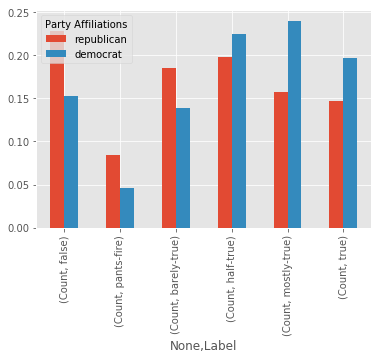

In [99]:
plt.style.use('ggplot')
ax = normalized_col_subject.plot(kind='bar')

---
## <font color=#303030> With what vocabulary?</font> 

Now, we would like to visualize which vocabulary is used by each speaker. To do this, we use the BeautifulSoup and WordCloud libraries.

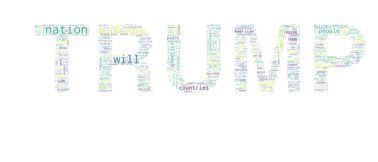

In [100]:
text = open('res/test_plain_text.txt').read() #President Donald Trump's statement to the United Nations General Assembly on Sept. 25, 2018.

trump_mask = np.array(Image.open('res/Trumpy3.png'))
wc = WordCloud(background_color="white", max_words=2000, mask=trump_mask,contour_width=0, contour_color='steelblue')
# generate word cloud
wc.generate(text)

# show the word cloud
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

----
----

## <font color=#303030>Our project: what is next?</font> 

### <font color=#856514>  The action plan </font> 

<div class="alert alert-block alert-info"><b>Our plan for the next weeks :</b><br />
<br />
- <b>Objective 1</b>:	

</div>

### <font color=#856514>   What is in our mind </font> 

As we have already pointed out on several occasions, our database is subject to many biases that make it difficult to generalize our results. Despite the goodwill of Politifact journalists and contributors, the sample presented in these data is certainly not representative of fakes news activity in the United States. While it is useful for classifying new data, it is not useful for drawing conclusions. What we want to do with this work is above all to exercise the skills we learned during the course and extract information from the data available. As we have seen, the relevance of this information must be confirmed through our critical thinking. We would therefore like to stress the importance of challenging the truth proclaimed through our results, in favour of the real truth. Distinguish between true and false through the verification of our sources, through a playful interface.